In [1]:
import json
import os

%load_ext dotenv
%dotenv

# f = open("authPaper.json")
# auth = json.load(f)

In [2]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
# BASE_URL = "https://paper-api.alpaca.markets"
# API_KEY = auth['ID']
# SECRET_KEY = auth['Secret']

In [3]:
api = tradeapi.REST(key_id= os.getenv('API_KEY'), secret_key=os.getenv('SECRET_KEY'), base_url=os.getenv('APCA_API_BASE_URL'), api_version='v2')

In [4]:
df_apple = api.get_bars("AAPL", TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df

<AxesSubplot:xlabel='timestamp'>

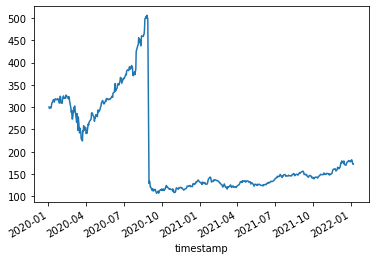

In [5]:
df_apple['close'].plot()

In [6]:
# importing forecasting libraries
import pmdarima as pm
import numpy as npf
import matplotlib.pyplot as plt
import seaborn as sn

In [7]:
arima_model = pm.auto_arima(df_apple['close'], seasonal = False)

# Random Walk (Useless)
A random walk does not help predict the next values only that the variance will increase... lame <br>
This is for predictions involving the closing cost

In [8]:
arima_model

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Forecasting Volume

We can see that volume is dependant on on previous lag with a ar and ma term.

In [9]:
arima_model = pm.auto_arima(df_apple['volume'], seasonal = False)

arima_model

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Correlation plot

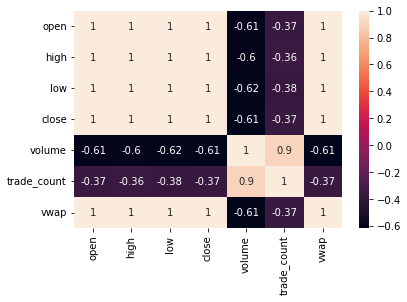

In [10]:
corrMatrix = df_apple.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [11]:
# building linear model
import statsmodels.api as sm
import math
from scipy import stats
from scipy import special
import pandas as pd
import numpy as np

## creating function to automate linear modeling with variables using forecasted predictors

In [12]:
# Setting to be function variables
stock = "AAPL"
test_set_length = 30

In [454]:
df_bars = api.get_bars(stock, TimeFrame.Day, "2020-01-01", "2022-07-02", adjustment='raw').df

df_bars

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2020-01-02 05:00:00+00:00,296.27,300.6000,295.1900,300.35,33920004,283490,298.439935
2020-01-03 05:00:00+00:00,296.95,300.5800,296.5000,297.43,36633995,280942,298.810386
2020-01-06 05:00:00+00:00,293.70,299.9600,292.7500,299.80,29644779,242867,297.799601
2020-01-07 05:00:00+00:00,299.98,300.9000,297.4800,298.39,27885664,227873,298.924596
2020-01-08 05:00:00+00:00,297.17,304.4399,297.1560,303.19,33091741,261777,301.165533
...,...,...,...,...,...,...,...
2022-06-27 04:00:00+00:00,142.70,143.4900,140.9650,141.66,73357944,516181,142.026287
2022-06-28 04:00:00+00:00,142.10,143.4220,137.3250,137.44,67315336,546241,139.375156
2022-06-29 04:00:00+00:00,137.44,140.6700,136.6700,139.23,66354959,572556,139.273624


Uses BoxCox tranformation to get closer to the norality assumption

In [455]:
transform_variables = ['close', 'volume', 'trade_count']
lambda_fitted = [None] * len(transform_variables)
# transform training data & save lambda value
for ind, variables in enumerate(transform_variables):
    transformed_data, fitted_lambda = stats.boxcox(df_bars[variables])
    
    df_bars[variables] = transformed_data
    
    lambda_fitted[ind] = fitted_lambda

Training and test setting

In [456]:
df_bars_train = df_bars[:-test_set_length]
df_bars_test = df_bars[-test_set_length:]

Fits a linear model using volume and trade_count as predictors with close price as the target

In [457]:
# building linear model
predictors = df_bars[['volume', 'trade_count']]
predictors = sm.add_constant(predictors)

fitted_linear = sm.OLS(df_bars['close'], predictors).fit()

fitted_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     692.0
Date:                Sun, 03 Jul 2022   Prob (F-statistic):          2.11e-159
Time:                        19:45:36   Log-Likelihood:                 5656.7
No. Observations:                 630   AIC:                        -1.131e+04
Df Residuals:                     627   BIC:                        -1.129e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5904   8.49e-05   6956.208      0.000       0.590       0.591
volume      -1.241e-06   4.25e-08    -29.196      0.000   -1.32e-06   -1.16e-06
trade_count     0.0002   8.88e-06     17.924      0.000       0.000       0.000
==============================================================================
Omnibus:                       16.660   Durbin-Watson:                   0.638
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.296
Skew:                           0.281   Prob(JB):                     2.37e-05
Kurtosis:                       3.703   Cond. No.                     3.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

adds constant to the test set and then gets the predicted variables from the fitted linear model

In [458]:
new_data_lm = sm.add_constant(df_bars_test[['volume', 'trade_count']])

test_pred_lm = fitted_linear.predict(new_data_lm)

# getting mae for linear model will be used to set trigger for buy and cell
np.mean(np.abs(special.inv_boxcox(test_pred_lm, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0])))

16.02297052900565

forecasting the predictor variables

In [459]:
arima_volume_model = pm.auto_arima(df_bars_train['volume'], seasonal = False)
arima_trade_model = pm.auto_arima(df_bars_train['trade_count'], seasonal = False)

goes through a loop to get a one step ahead forecast adding another observation of data to the original forecasted models <br>
and then saves the forecast to test lists

In [460]:
test_volume_error = []
test_trade_error = []

for i in range((test_set_length), 0, -1):
    
    tmp_volume_model = arima_volume_model
    tmp_trade_model = arima_trade_model

    if (i == 30):
        
        test_volume_error.append(tmp_volume_model.predict(n_periods = 1)[0])
        
        test_trade_error.append(arima_trade_model.predict(n_periods = 1)[0])
    else:
        tmp_volume_model.update(df_bars_test[i:].volume)
        
        test_volume_error.append(tmp_volume_model.predict(n_periods = 1)[0])
        
        tmp_trade_model.update(df_bars_test[i:].trade_count)
        
        test_trade_error.append(tmp_trade_model.predict(n_periods = 1)[0])

Getting the accuracy measures from the forecasts

In [461]:
# getting mae for volume one step ahead forecasts
np.mean(np.abs(special.inv_boxcox(test_volume_error, lambda_fitted[1]) - special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1])))

17625933.76565292

In [462]:
# getting mape for volume
np.mean(np.abs(special.inv_boxcox(test_volume_error, lambda_fitted[1]) - special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1]))/special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1]))

0.17612089795769484

In [463]:
# getting mae for volume one step ahead for trade_count
np.mean(np.abs(special.inv_boxcox(test_trade_error, lambda_fitted[2]) - special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2])))

128697.25486131552

In [464]:
# mape for trade_count
np.mean(np.abs(special.inv_boxcox(test_trade_error, lambda_fitted[2]) - special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2]))/ special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2]))

0.16415699554494698

Using the forecasted predictor values to get estimated target variables and viewing the accuracy

In [465]:
# instead of using the actual testset to test linear model use the forecasted
df_new_forecast = pd.DataFrame({'volume': test_volume_error, 'trade_count': test_trade_error})
# if mape is smaller than .5, we are acurate more than 50% of the time...

df_new_forecast = sm.add_constant(df_new_forecast)

pred_lm_forecast = fitted_linear.predict(df_new_forecast)

In [466]:
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True)))

17.569763405395936

In [467]:
# getting standard deviation to see the spread of the data
1.96*np.std(special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]))

11.304526606521588

In [468]:
# mape for the forecasted new dataset using one step ahead forecasts
# getting 10% is pretty great from forecast to a linear model.. 
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True))/special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True))

0.1267557095326016

# Using PCA and applied previous method to predict closing price

In [469]:
# Calls libraries used for pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [470]:
# 50 top stocks
stock_list = ['DIDI', 'AMD', 'AAPL', 'AMZN', 'CCL', 'NIO', 'F', 'BBD', 'ITUB', \
             'ABEV', 'BABA', 'NVDA', 'NOK', 'AAL', 'DOCU', 'SNAP', 'PCG', 'SOFI', \
             'SWN', 'INTC', 'AUY', 'CERN', 'PBR', 'T', 'TSLA', 'GRAB', 'NCLH', \
             'NU', 'MSFT', 'NLY', 'PLTR', 'UBER', 'WFC', 'META', 'XOM', 'MU', \
             'OXY', 'AMC', 'WBD', 'RIG', 'CS', 'OPEN', 'RBLX', 'PFE', 'PDD', \
             'FCX', 'GFI', 'DKNG']

In [471]:
df_group_bars = pd.DataFrame()

# runs through list of stocks and pulls a given stock and concatinates that onto a main df. it also creates a stock column,
# which is just the stock name
for stocks in stock_list:
    
    if (len(df_group_bars) == 0):
        
        df_group_bars = api.get_bars(stocks, TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df
        
        df_group_bars['stock'] = stocks
    else:
    
        df_temp_stock = api.get_bars(stocks, TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df
        
        df_temp_stock['stock'] = stocks
        
        df_group_bars = pd.concat([df_group_bars, df_temp_stock])

In [472]:
# Sets up for data pivot to wider
df_group_bars['datetime'] = df_group_bars.index
df_group_bars['datetime'] = pd.to_datetime(df_group_bars['datetime'])
# df_group_bars.pivot(index='patient', columns='obs', values='score')

In [473]:
# pivots data
df_pivot_bars = df_group_bars.pivot(index='datetime', columns='stock', values=['close', 'volume', 'trade_count'])

In [474]:
# drops multi index from pivot
df_pivot_bars.columns = df_pivot_bars.columns.get_level_values(0) + '_' +  df_pivot_bars.columns.get_level_values(1)

In [475]:
# picking the target variable, of course I'm choosing Apple
target = df_pivot_bars.pop('close_AAL')

In [476]:
# scalling the data for pca
df_scaled_bars = StandardScaler().fit_transform(df_pivot_bars.dropna(axis = 'columns'))

In [477]:
# Afters short analysis, I have chosen to get only 5 pca
pca = PCA(n_components = 5)

principalComponents = pca.fit_transform(df_scaled_bars)

principalDf = pd.DataFrame(data = principalComponents)

principalDf['Target'] = target.reset_index(drop = True)

transformed_principal, fitted_lambda = stats.boxcox(principalDf['Target'])

principalDf['Target'] = transformed_principal

<AxesSubplot:>

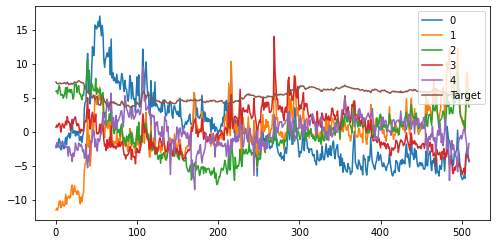

In [478]:
principalDf.plot()

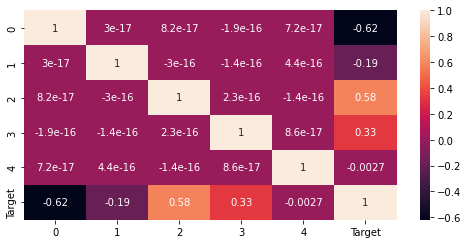

In [479]:
# correlation plot with target and pca
corrMatrix = principalDf.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [480]:
df_pca_train = principalDf[30:]
df_pca_test =  principalDf[:30]

In [481]:
# building linear model
predictors = df_pca_train[[0,1,2,3,4]]
predictors_cons = sm.add_constant(predictors)

fitted_linear = sm.OLS(df_pca_train['Target'], predictors_cons).fit()

fitted_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     476.1
Date:                Sun, 03 Jul 2022   Prob (F-statistic):          3.40e-182
Time:                        19:46:06   Log-Likelihood:                -174.21
No. Observations:                 480   AIC:                             360.4
Df Residuals:                     474   BIC:                             385.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4281      0.017    320.512      0.000       5.395       5.461
0             -0.1165      0.003    -36.842      0.000      -0.123      -0.110
1             -0.0340      0.006     -5.515      0.000      -0.046      -0.022
2              0.1459      0.006     26.416      0.000       0.135       0.157
3              0.1045      0.005     19.026      0.000       0.094       0.115
4              0.0081      0.008      1.067      0.286      -0.007       0.023
==============================================================================
Omnibus:                        2.878   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.676
Skew:                           0.141   Prob(JB):                        0.262
Kurtosis:                       3.234   Cond. No.                         5.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Generates a fitted forecast of each pca and then saves each one into a list

In [482]:
forecast_list = []
for col in df_pca_train.columns:
    forecast_list.append(pm.auto_arima(df_pca_train[col], seasonal = False))

In [483]:
df_step_ahead_forecast = pd.DataFrame()

# for loops goes through each predictor column and then gets a one step ahead forecast by slowing updating the fitted models
# with one more observation using a for loop. The forecasted values are then saved to a dataframe
for col in df_pca_test.columns[:-1]:
    
    test_forecast = []
    
    forecast_model_col = forecast_list[col]
    
    for i in range(len(df_pca_test), 0, -1):
        
        tmp_forecast_model = forecast_model_col
        
        if (i == 30):
        
            test_forecast.append(tmp_forecast_model.predict(n_periods = 1)[0])
        else:
            
            tmp_forecast_model.update(df_pca_test[col][i:])

            test_forecast.append(tmp_forecast_model.predict(n_periods = 1)[0])
    
    df_step_ahead_forecast[col] = test_forecast

Gets predicted values from the linear model using the forecasted predictor values

In [484]:
df_new_forecast = sm.add_constant(df_step_ahead_forecast)

pred_lm_forecast = fitted_linear.predict(df_new_forecast)

In [485]:
# mae for forecasted variables as predictors of the closed amount.
# 2 dollars is a pretty decent mae 
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)))

3.0388430196503444

In [486]:
np.std(special.inv_boxcox(df_pca_test['Target'], fitted_lambda))

1.0029007373059866

In [487]:
# mape for the forecasted new dataset using one step ahead forecasts
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)) / special.inv_boxcox(df_pca_test['Target'], fitted_lambda))

0.10731154462517067

In [488]:
# possible bias in these models... It is always lower than the actual
special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)

0    -9.654599
1    -4.645402
2    -3.493941
3    -2.634725
4    -2.814138
5    -2.739596
6    -2.016237
7    -2.051011
8    -2.200853
9    -2.272072
10   -2.941940
11   -3.116747
12   -1.926327
13   -2.042245
14   -3.522782
15   -2.363289
16   -0.829360
17   -1.617287
18   -1.512658
19   -2.428525
20   -1.546726
21   -1.862559
22   -3.130817
23   -3.798857
24   -2.998361
25   -3.073656
26   -3.479530
27   -4.526168
28   -5.154064
29   -4.770817
dtype: float64

## Technical analysis

In [489]:
# inport necessary libraries
import talib as tb
import random

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [490]:
macd, macdsignal, macdhist = tb.MACD(df_apple['close'], fastperiod=12, slowperiod=26, signalperiod=9)

In [491]:
# creates a macD dataframe using talib and then merges original dataset onto it
df_mac = pd.DataFrame({'macd': macd, 'macdsignal': macdsignal, 'macdhist':macdhist})

df_mac = df_mac.merge(df_apple, left_index=True, right_index=True)
df_mac['MOM'] = tb.MOM(df_apple['close'], timeperiod=5)

for i in range(2, 13):
    df_mac['MA_' + str(i)] = tb.SMA(df_apple['close'], timeperiod=i)

In [492]:
df_mac

,macd,macdsignal,macdhist,open,high,low,close,volume,trade_count,vwap,...,MA_3,MA_4,MA_5,MA_6,MA_7,MA_8,MA_9,MA_10,MA_11,MA_12
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-02 05:00:00+00:00,NaN,NaN,NaN,296.27,300.6000,295.190,300.350,33920004,283490,298.439935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 05:00:00+00:00,NaN,NaN,NaN,296.95,300.5800,296.500,297.430,36633995,280942,298.810386,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06 05:00:00+00:00,NaN,NaN,NaN,293.70,299.9600,292.750,299.800,29644779,242867,297.799601,...,299.193333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07 05:00:00+00:00,NaN,NaN,NaN,299.98,300.9000,297.480,298.390,27885664,227873,298.924596,...,298.540000,298.99250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08 05:00:00+00:00,NaN,NaN,NaN,297.17,304.4399,297.156,303.190,33091741,261777,301.165533,...,300.460000,299.70250,299.832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03 05:00:00+00:00,4.818780,4.982143,-0.163363,177.81,182.8800,177.710,182.010,104690466,772367,181.415512,...,179.260000,179.29000,179.290,179.463333,179.008571,178.587500,177.965556,177.1440,176.598182,176.236667
2022-01-04 05:00:00+00:00,4.672654,4.920245,-0.247591,182.61,182.9400,179.120,179.700,99284337,831619,180.555450,...,179.760000,179.37000,179.372,179.358333,179.497143,179.095000,178.711111,178.1390,177.376364,176.856667
2022-01-05 05:00:00+00:00,4.116827,4.759562,-0.642734,179.61,180.1700,174.650,174.835,86753815,844519,177.497784,...,178.848333,178.52875,178.463,178.615833,178.712143,178.914375,178.621667,178.3235,177.838636,177.164583


In [493]:
# shisfts close back one to get tomorrow's close price
df_mac['next_day_close'] = df_mac['close'].shift(periods=-1, axis="index")

In [494]:
# creates a boolean columns on if the next day is higher than the previous
df_mac['higher_than_yesterday'] = np.where(df_mac['next_day_close'] > df_mac['close'], 1, 0)

In [495]:
df_mac_nona = df_mac.loc[(~df_mac['macdhist'].isna()) & ~(df_mac['next_day_close'].isna()),]

In [496]:
random.seed(10)

# define the model
random_forest_macd = RandomForestClassifier()
# evaluate the model
random_forest_macd.fit(df_mac_nona[['MA_10', 'macdhist']], df_mac_nona['higher_than_yesterday'])

RandomForestClassifier()

completely random

In [497]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(random_forest_macd, df_mac_nona[['close','macdhist']], df_mac_nona['higher_than_yesterday'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.506 (0.056)


In [498]:
# let's build no model and just get the percentage of being above the certain shift forwards. Use difference between the
# macd to use a velocity... maybe the faster the machhist the more likely the closing price will be maintain a trend.

In [499]:
from statsmodels.tsa.stattools import adfuller

In [500]:
# creates a boolean columns on if the next day is higher than the previous
df_mac['macd_positive'] = np.where(df_mac['MA_5'] > 0, 1, 0)

In [501]:
df_mac.groupby(by = ["macd_positive"]).agg({'close':['mean','std']})

close            
                     mean         std
macd_positive                        
0              298.992500    1.329069
1              199.547515  100.138242

# augmented dickey fuller test function
if we do not reject null hypothesis implies that the data is not stationary

In [502]:
# takes in time series data vector
# prints out test statistics and returns the p-value
def adf_test(ts_array, print_test_stats):
    dickeyfuller = adfuller(ts_array)
    if (print_test_stats):
        print('ADF Statistic: %f' % dickeyfuller[0])
        print('p-value: %f' % dickeyfuller[1])
        print('Critical Values:')
        for key, value in dickeyfuller[4].items():
            print('\t%s: %.3f' % (key, value))
    else:
        return(dickeyfuller[1])

In [503]:
adf_test(df_mac['close'], False)

0.25197972726386353

making stationary value

In [504]:
df_mac['close_stationary'] = df_mac['close'] - df_mac['close'].shift(periods=1, axis="index")

In [505]:
# retesting
adf_test(df_mac['close_stationary'].dropna(), True)

ADF Statistic: -23.232615
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [506]:
df_mac.groupby(by = ["macd_positive"]).agg({'close_stationary':['mean','std']})

close_stationary           
                          mean        std
macd_positive                            
0                    -0.653333   2.724965
1                    -0.249447  17.458504

# Decision Trees
And giving specific instructions of what to use, so visualization is "easy"
First create df with common indicators

In [507]:
from sklearn import tree
import graphviz
import itertools

In [508]:
# ripped off my earlier code
macd, macdsignal, macdhist = tb.MACD(df_apple['close'], fastperiod=12, slowperiod=26, signalperiod=9)
# creates a macD dataframe using talib and then merges original dataset onto it
df_mac = pd.DataFrame({'macd': macd, 'macdsignal': macdsignal, 'macdhist':macdhist})

df_mac = df_mac.merge(df_apple, left_index=True, right_index=True)
df_mac['MOM'] = tb.MOM(df_apple['close'], timeperiod=5)
df_mac['SAR'] = tb.SAR(df_apple['high'], df_apple['low'])

# create stationary time series
if (adf_test(df_mac['close'], False) > 0.05):
    df_mac['close'] = df_mac['close'] - df_mac['close'].shift(periods=1, axis="index")
    
for i in [21]:
    df_mac['MA_' + str(i)] = tb.SMA(df_mac['close'], timeperiod=i)

for i in [21]:
    df_mac['EMA_' + str(i)] = tb.EMA(df_mac['close'], timeperiod=i)

df_mac['std'] = df_mac['close'].rolling(30).std()

In [509]:
df_mac = df_mac.dropna(axis = 0, how = 'any')

## Fitting that tree with small number of features and nodes

fits a regression tree using very restictive options to create thresholds, easy to implement

In [510]:
mac_tree = tree.DecisionTreeRegressor(criterion = "absolute_error", max_features = 3, max_leaf_nodes = 3)
mac_tree = mac_tree.fit(X = df_mac.drop(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], axis = 1),\
                        y = df_mac['close'])

### plots the fitted calssification tree

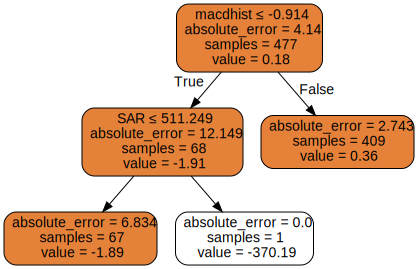

In [511]:
dot_data = tree.export_graphviz(mac_tree, out_file=None, \
                                feature_names=df_mac.drop(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], axis = 1).columns,\
                                filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

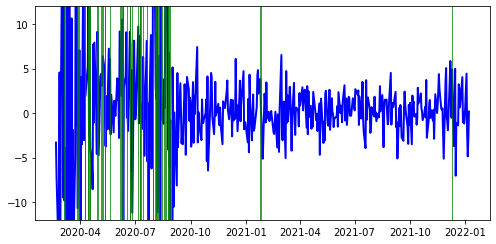

In [522]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x = df_mac.index
y = df_mac['close']
plt.plot(x, y, c='blue', lw=2)
plt.ylim([-12, 12])
plt.vlines((df_mac.loc[df_mac['MOM'] > 11.35].index), ymin = -12, ymax = 12, color='green', alpha=0.75, lw=1)
plt.show()


In [425]:
# produces list of regression tree with thresholds
saved_features = zip(df_mac.drop(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], axis = 1).columns[mac_tree.tree_.feature],\
                     mac_tree.tree_.impurity,\
                     mac_tree.tree_.threshold,\
                     mac_tree.tree_.children_left,\
                     mac_tree.tree_.children_right,\
                     list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(mac_tree.tree_.value.tolist())))))

list(saved_features)

### creating df stock indexes by cap size and sector

In [427]:
# Communication stocks
com_stock = ['GOOGL', 'Large',\
 'META', 'Large',\
 'VZ', 'Large',\
 'DIS', 'Large',\
 'CMCSA', 'Large',\
 'TMUS', 'Large',\
 'T', 'Large',\
 'NFLX', 'Large',\
 'CHTR', 'Large',\
 'NTES', 'Large']

# Consumer Discretionary
consumer_dis_stock = ['AMZN', 'Large',\
                 'TSLA', 'Large',\
                 'LVMHF', 'Large',\
                 'HD', 'Large',\
                 'TM', 'Large',\
                 'NKE', 'Large',\
                 'MCD', 'Large',\
                 'VWAGY', 'Large',\
                 'HESAY', 'Large',\
                 'LOW', 'Large',\
                 'APTV', 'Mid',\
                 'SCI', 'Mid',\
                 'WSM', 'Mid',\
                 'GME', 'Mid',\
                 'FIVE', 'Mid',\
                 'LAD', 'Mid',\
                 'DHI', 'Mid',\
                 'LEN', 'Mid',\
                 'ORLY', 'Mid',\
                 'EBAY', 'Small',\
                 'FL', 'Mid',\
                 'COUR', 'Small']
# Consumer Staples
consumer_sta_stocks = ['WMT', 'Large',\
                       'PG', 'Large',\
                       'NSRGY', 'Large',\
                       'KO', 'Large',\
                       'COST', 'Large',\
                       'PEP', 'Large',\
                       'LRLCY', 'Large',\
                       'PM', 'Large',\
                       'UL', 'Large',\
                       'TGT', 'Large']
# energy 
energy_stocks = ['XOM', 'Large',\
                 'CVX', 'Large',\
                 'RYDAF', 'Large',\
                 'TTE', 'Large',\
                 'COP', 'Large',\
                 'EQNR', 'Large',\
                 'BP', 'Large',\
                 'PTR', 'Large',\
                 'ENB', 'Large',\
                 'PBR', 'Large',\
                 'XOM', 'Large']
# Financial  
finance_stocks = ['BRK.A', 'Large',\
                  'V', 'Large',\
                  'JPM', 'Large',\
                  'MA', 'Large',\
                  'BAC', 'Large',\
                  'IDCBY', 'Large',\
                  'CICHY', 'Large',\
                  'WFC', 'Large',\
                  'MS', 'Large',\
                  'C', 'Large',\
                  'WFC', 'Large',\
                  'BFH', 'Mid']
# health  
health_stocks = ['JNJ', 'Large',\
                 'UNH', 'Large',\
                 'PFE', 'Large',\
                 'LLY', 'Large',\
                 'RHHBY', 'Large',\
                 'NVO', 'Large',\
                 'MRK', 'Large',\
                 'TMO', 'Large',\
                 'DHR', 'Large',\
                 'ABT', 'Large',\
                 'OPRX', 'Small',\
                 'GBT', 'Small']
# Industrial   
indus_stocks = ['UPS', 'Large',\
                 'RTX', 'Large',\
                 'UNP', 'Large',\
                 'HON', 'Large',\
                 'CAT', 'Large',\
                 'DE', 'Large',\
                 'SIEGY', 'Large',\
                 'GE', 'Large',\
                 'BA', 'Large',\
                 'X', 'Mid']
# Materials   
mater_stocks = ['BHP', 'Large',\
                 'LIN', 'Large',\
                 'RIO', 'Large',\
                 'AIQUY', 'Large',\
                 'VALE', 'Large',\
                 'GLNCY', 'Large',\
                 'SHW', 'Large',\
                 'SHECY', 'Large',\
                 'ECL', 'Large']
# Real Estate   
property_stocks = ['AMT', 'Large',\
                     'PLD', 'Large',\
                     'CCI', 'Large',\
                     'DLR', 'Large',\
                     'EQIX', 'Large',\
                     'SPG', 'Large',\
                     'PSA', 'Large',\
                     'O', 'Large',\
                     'WELL', 'Large', \
                     'SBAC', 'Large']
# Technology    
tech_stocks = ['AAPL', 'Large',\
                 'MSFT', 'Large',\
                 'TSM', 'Large',\
                 'NVDA', 'Large',\
                 'TCEHY', 'Large',\
                 '005930.KS', 'Large',\
                 'BABA', 'Large',\
                 'ASML', 'Large',\
                  'FOUR', 'Small',\
                  'FLYW', 'Small',\
                  'AMBA', 'Mid']
# Utilities    
util_stocks = ['NEE', 'Large',\
                 'DUK', 'Large',\
                 'SO', 'Large',\
                 'D', 'Large',\
                 'AEP', 'Large',\
                 'SRE', 'Large',\
                 'EXC', 'Large',\
                 'XEL', 'Large',\
                 'PEG', 'Large',\
                  'FLNC', 'Small',\
                  'NOVA', 'Small']
# Defense 
def_stocks = ['GD', 'Large',\
              'LMT', 'Large',\
              'RTX', 'Large']

In [428]:
# multi list with hand created index lists
list_sector_index = [com_stock, consumer_dis_stock, consumer_sta_stocks, energy_stocks, finance_stocks, health_stocks, \
              indus_stocks, mater_stocks, property_stocks, tech_stocks, util_stocks, def_stocks]
# list of sectors
list_of_sectors = ['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financial', 'Healthcare',\
                   'Industrial', 'Materials', 'Real Estate', 'Technology', 'Utilities', 'Defense']
#  empty list to append
arrayofsec = []
# creates repeats the sector name the number of times the value occurs 
for i, string in enumerate(list_of_sectors):
    arrayofsec.append(list(itertools.chain(np.repeat(string, len(list_sector_index[i][1::2])))))

In [429]:
# creates function to flatten nested lists
def flatten(xss):
    return [x for xs in xss for x in xs]
# flattens arrayofsec
flat_sector = flatten(arrayofsec)

In [431]:
df_index = pd.DataFrame({'Index': flatten(list_sector_index)[::2], 'Cap size': flatten(list_sector_index)[1::2], 'Sector': flat_sector})

In [434]:
df_index.tail(10)

,Index,Cap size,Sector
121,AEP,Large,Utilities
122,SRE,Large,Utilities
123,EXC,Large,Utilities
124,XEL,Large,Utilities
125,PEG,Large,Utilities
126,FLNC,Small,Utilities
127,NOVA,Small,Utilities
128,GD,Large,Defense
129,LMT,Large,Defense
130,RTX,Large,Defense
